# 0527_model epoch 250---정확도 0.4 나와서 좋지 않음

CSV 파일에서 데이터를 로드합니다.

데이터를 훈련 데이터와 테스트 데이터로 분리합니다.

데이터를 2D CNN 입력 형태로 변환합니다.

레이블을 원-핫 인코딩합니다.

모델을 로드합니다.

추가로 100 에포크 동안 훈련합니다.

업데이트된 모델을 저장합니다.

모델 성능을 평가하고 시각화합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

# 모델 로드
loaded_model = load_model('/content/drive/My Drive/soundAI/0527_model.h5')
print("Model loaded successfully.")


Model loaded successfully.


Model loaded successfully.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1023, 128, 32)     320       
                                                                 
 batch_normalization (Batch  (None, 1023, 128, 32)     128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 64, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 511, 64, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 62, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model updated and saved successfully.
5/5 [==============================] - 0s 44ms/step - loss: 76.4101 - accuracy: 0.4558
Test accuracy: 0.45578232407569885


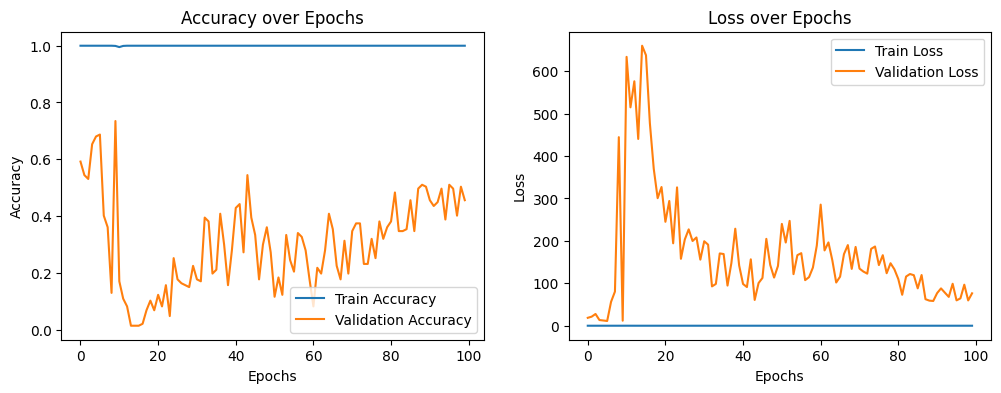

In [ ]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import torch

# 문자열을 실제 텐서로 변환하는 함수
def convert_to_tensor(tensor_str):
    tensor_list = ast.literal_eval(tensor_str)
    tensor = torch.tensor(tensor_list)
    return tensor

# 'feature' 열의 문자열을 실제 텐서로 변환하여 다시 저장
df = pd.read_csv('/content/drive/My Drive/soundAI/df_concat.csv')
df['feature'] = df['feature'].apply(convert_to_tensor)

# 노이즈 추가 함수 정의
def add_noise(tensor, noise_level=0.01):
    noise = np.random.normal(0, noise_level, tensor.shape)
    return tensor + noise

# 데이터 증강 함수
def augment_data(df, num_augmentations=10, noise_level=0.01):
    augmented_features = []
    augmented_labels = []

    for _, row in df.iterrows():
        feature = np.array(row['feature'])
        label = row['label']

        augmented_features.append(feature)  # 원본 데이터 추가
        augmented_labels.append(label)

        for _ in range(num_augmentations - 1):
            augmented_feature = add_noise(feature, noise_level)
            augmented_features.append(augmented_feature)
            augmented_labels.append(label)

    augmented_df = pd.DataFrame({
        'feature': augmented_features,
        'label': augmented_labels
    })
    return augmented_df

# 데이터 증강 실행
augmented_df = augment_data(df)

# 패딩 함수 정의
def pad_feature(feature, target_shape=(1025, 130), pad_value=-1):
    current_shape = feature.shape
    if current_shape == target_shape:
        return feature
    padded_feature = np.full(target_shape, pad_value)
    padded_feature[:current_shape[0], :current_shape[1]] = feature
    return padded_feature

# 각 행마다 패딩 적용
augmented_df['feature'] = augmented_df['feature'].apply(lambda x: pad_feature(np.array(x)))
df['feature'] = df['feature'].apply(lambda x: pad_feature(np.array(x)))

# augmented_df의 레이블을 오름차순 정렬하고 매핑 생성
unique_labels = np.sort(augmented_df['label'].unique())
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# 매핑을 적용하여 레이블 변환
augmented_df['label'] = augmented_df['label'].map(label_mapping)
df['label'] = df['label'].map(label_mapping)

# 데이터 및 레이블 준비
X_train = np.stack(augmented_df['feature'].values)
y_train = augmented_df['label'].values

X_test = np.stack(df['feature'].values)
y_test = df['label'].values

# 데이터 형태 조정 (2D CNN 입력 형태로 맞춤)
X_train = X_train[..., np.newaxis]  # (samples, height, width, channels)
X_test = X_test[..., np.newaxis]  # (samples, height, width, channels)

# 레이블 원-핫 인코딩
num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# 기존 모델 로드
model = load_model('/content/drive/My Drive/soundAI/0527_model.h5')
print("Model loaded successfully.")

# 모델 요약 출력
model.summary()

# 모델 훈련 (추가 100 에포크)
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=100, batch_size=32)

# 모델 저장
#model.save('/content/drive/My Drive/soundAI/0527_model_updated.h5')
#print("Model updated and saved successfully.")

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {accuracy}')

# 정확도와 손실 값을 시각화하는 함수
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # 손실 값 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

# 정확도와 손실 값 시각화
plot_history(history)


5/5 [==============================] - 0s 45ms/step


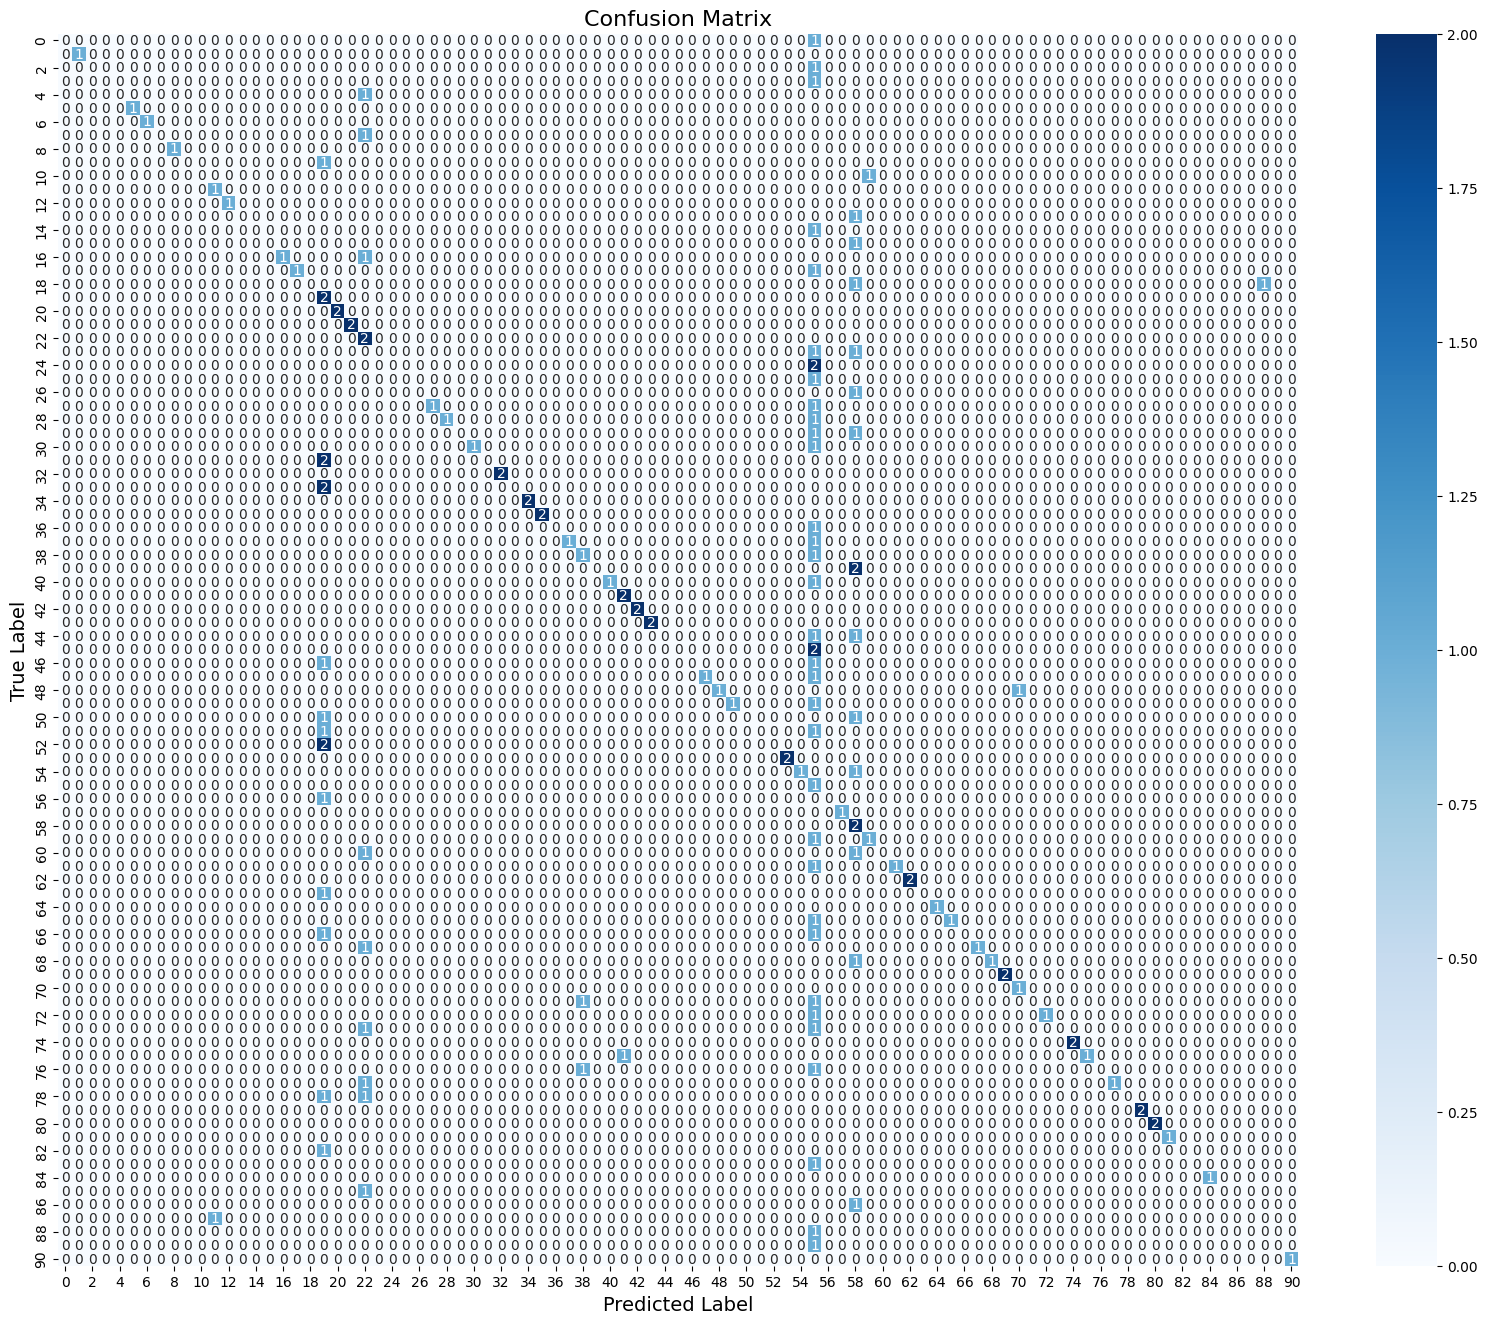

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 예측값
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [ ]:
# 모델 저장
model.save('/content/drive/My Drive/soundAI/0601_model.h5')
print("Model updated and saved successfully.")

Model loaded successfully.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1023, 128, 32)     320       
                                                                 
 batch_normalization (Batch  (None, 1023, 128, 32)     128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 64, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 511, 64, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 62, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model updated and saved successfully.
5/5 [==============================] - 0s 45ms/step - loss: 151.2400 - accuracy: 0.4830
Test accuracy: 0.4829931855201721


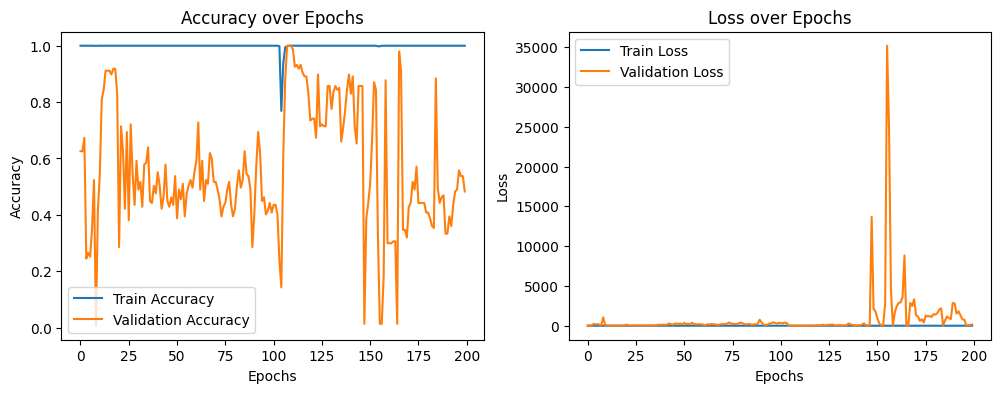

In [ ]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import torch

# 문자열을 실제 텐서로 변환하는 함수
def convert_to_tensor(tensor_str):
    tensor_list = ast.literal_eval(tensor_str)
    tensor = torch.tensor(tensor_list)
    return tensor

# 'feature' 열의 문자열을 실제 텐서로 변환하여 다시 저장
df = pd.read_csv('/content/drive/My Drive/soundAI/df_concat.csv')
df['feature'] = df['feature'].apply(convert_to_tensor)

# 노이즈 추가 함수 정의
def add_noise(tensor, noise_level=0.01):
    noise = np.random.normal(0, noise_level, tensor.shape)
    return tensor + noise

# 데이터 증강 함수
def augment_data(df, num_augmentations=10, noise_level=0.01):
    augmented_features = []
    augmented_labels = []

    for _, row in df.iterrows():
        feature = np.array(row['feature'])
        label = row['label']

        augmented_features.append(feature)  # 원본 데이터 추가
        augmented_labels.append(label)

        for _ in range(num_augmentations - 1):
            augmented_feature = add_noise(feature, noise_level)
            augmented_features.append(augmented_feature)
            augmented_labels.append(label)

    augmented_df = pd.DataFrame({
        'feature': augmented_features,
        'label': augmented_labels
    })
    return augmented_df

# 데이터 증강 실행
augmented_df = augment_data(df)



# 패딩 함수 정의
def pad_feature(feature, target_shape=(1025, 130), pad_value=-1):
    current_shape = feature.shape
    if current_shape == target_shape:
        return feature
    padded_feature = np.full(target_shape, pad_value)
    padded_feature[:current_shape[0], :current_shape[1]] = feature
    return padded_feature

# 각 행마다 패딩 적용
augmented_df['feature'] = augmented_df['feature'].apply(lambda x: pad_feature(np.array(x)))
df['feature'] = df['feature'].apply(lambda x: pad_feature(np.array(x)))

# augmented_df의 레이블을 오름차순 정렬하고 매핑 생성
unique_labels = np.sort(augmented_df['label'].unique())
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# 매핑을 적용하여 레이블 변환
augmented_df['label'] = augmented_df['label'].map(label_mapping)
df['label'] = df['label'].map(label_mapping)

# 데이터 및 레이블 준비
X_train = np.stack(augmented_df['feature'].values)
y_train = augmented_df['label'].values

X_test = np.stack(df['feature'].values)
y_test = df['label'].values

# 데이터 형태 조정 (2D CNN 입력 형태로 맞춤)
X_train = X_train[..., np.newaxis]  # (samples, height, width, channels)
X_test = X_test[..., np.newaxis]  # (samples, height, width, channels)

# 레이블 원-핫 인코딩
num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# 기존 모델 로드
model = load_model('/content/drive/My Drive/soundAI/0527_model.h5')
print("Model loaded successfully.")

# 모델 요약 출력
model.summary()

# 모델 훈련 (추가 100 에포크)
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=200, batch_size=32)

# 모델 저장
model.save('/content/drive/My Drive/soundAI/0529_250E.h5')
print("Model updated and saved successfully.")

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {accuracy}')

# 정확도와 손실 값을 시각화하는 함수
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # 손실 값 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

# 정확도와 손실 값 시각화
plot_history(history)


# 0529
'/content/drive/My Drive/soundAI/0601_model.h5'
0.99

이거 돌리기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{(1025, 130), (1025, 87)}
{(1025, 130), (1025, 87)}
{(1025, 130)}
{(1025, 130)}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1023, 128, 32)     320       
                                                                 
 batch_normalization (Batch  (None, 1023, 128, 32)     128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 64, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 511, 64, 32)       0         
                                             

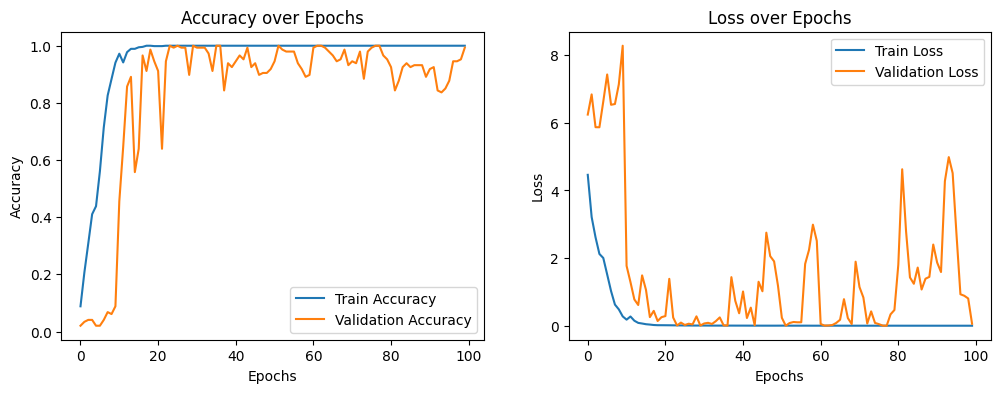

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model updated and saved successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/content/drive/My Drive/soundAI/df_concat.csv')

# 문자열을 실제 텐서로 변환하는 함수
def convert_to_tensor(tensor_str):
    tensor_list = ast.literal_eval(tensor_str)
    tensor = torch.tensor(tensor_list)
    return tensor

# 'feature' 열의 문자열을 실제 텐서로 변환하여 다시 저장
df['feature'] = df['feature'].apply(convert_to_tensor)

# 노이즈 추가 함수 정의
def add_noise(tensor, noise_level=0.01):
    noise = np.random.normal(0, noise_level, tensor.shape)
    return tensor + noise

# 데이터 증강 함수
def augment_data(df, num_augmentations=10, noise_level=0.01):
    augmented_features = []
    augmented_labels = []

    for _, row in df.iterrows():
        feature = np.array(row['feature'])
        label = row['label']

        augmented_features.append(feature)  # 원본 데이터 추가
        augmented_labels.append(label)

        for _ in range(num_augmentations - 1):
            augmented_feature = add_noise(feature, noise_level)
            augmented_features.append(augmented_feature)
            augmented_labels.append(label)

    # 데이터프레임 생성
    augmented_df = pd.DataFrame({
        'feature': augmented_features,
        'label': augmented_labels
    })
    return augmented_df

# 데이터 증강 실행
augmented_df = augment_data(df)

# 무음 데이터 생성 함수
def generate_silence_data(target_shape=(1025, 130)):
    return np.zeros(target_shape)

# 무음 데이터 추가
def add_silence_data(df, target_shape=(1025, 130)):
    silence_feature = generate_silence_data(target_shape)
    silence_label = -1  # silence 레이블을 숫자로 표시

    silence_df = pd.DataFrame({
        'feature': [torch.tensor(silence_feature)],
        'label': [silence_label]
    })

    augmented_df_with_silence = pd.concat([df, silence_df], ignore_index=True)
    return augmented_df_with_silence

# 무음 데이터 추가
augmented_df_with_silence = add_silence_data(augmented_df)

# 무음 데이터를 추가한 후 레이블을 다시 매핑
unique_labels_with_silence = np.sort(augmented_df_with_silence['label'].unique())
label_mapping_with_silence = {old_label: new_label for new_label, old_label in enumerate(unique_labels_with_silence)}

augmented_df_with_silence['label'] = augmented_df_with_silence['label'].map(label_mapping_with_silence)

# 기존 데이터프레임에도 동일한 레이블 매핑 적용
df['label'] = df['label'].map(label_mapping_with_silence)

# 각 행마다 feature의 차원을 확인하고 중복을 제거하여 출력
feature_dimensions = [np.array(feature).shape for feature in augmented_df_with_silence['feature']]
unique_dimensions = set(feature_dimensions)
print(unique_dimensions)

feature_dimensions = [np.array(feature).shape for feature in df['feature']]
unique_dimensions = set(feature_dimensions)
print(unique_dimensions)

# 패딩 함수 정의
def pad_feature(feature, target_shape=(1025, 130), pad_value=-1):
    current_shape = feature.shape
    if current_shape == target_shape:
        return feature
    padded_feature = np.full(target_shape, pad_value)
    padded_feature[:, :current_shape[1]] = feature
    return padded_feature

# 각 행마다 패딩 적용
augmented_df_with_silence['feature'] = augmented_df_with_silence['feature'].apply(lambda x: pad_feature(np.array(x)))
df['feature'] = df['feature'].apply(lambda x: pad_feature(np.array(x)))

# 각 feature의 차원을 확인하여 중복 제거 후 출력
feature_dimensions = [feature.shape for feature in augmented_df_with_silence['feature']]
unique_dimensions = set(feature_dimensions)
print(unique_dimensions)

feature_dimensions = [feature.shape for feature in df['feature']]
unique_dimensions = set(feature_dimensions)
print(unique_dimensions)

# 데이터 및 레이블 준비
X_train = np.stack(augmented_df_with_silence['feature'].values)
y_train = augmented_df_with_silence['label'].values

X_test = np.stack(df['feature'].values)
y_test = df['label'].values

# 데이터 형태 조정 (2D CNN 입력 형태로 맞춤)
X_train = X_train[..., np.newaxis]  # (samples, height, width, channels)
X_test = X_test[..., np.newaxis]  # (samples, height, width, channels)

# 레이블 원-핫 인코딩
num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

# 2D CNN 모델 정의
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(1025, 130, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=100, batch_size=32)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {accuracy}')

# 정확도와 손실 값을 시각화하는 함수
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # 손실 값 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

# 정확도와 손실 값 시각화
plot_history(history)

# 모델 저장
model.save('/content/drive/My Drive/soundAI/0601_model.h5')
print("Model updated and saved successfully.")


5/5 [==============================] - 0s 44ms/step


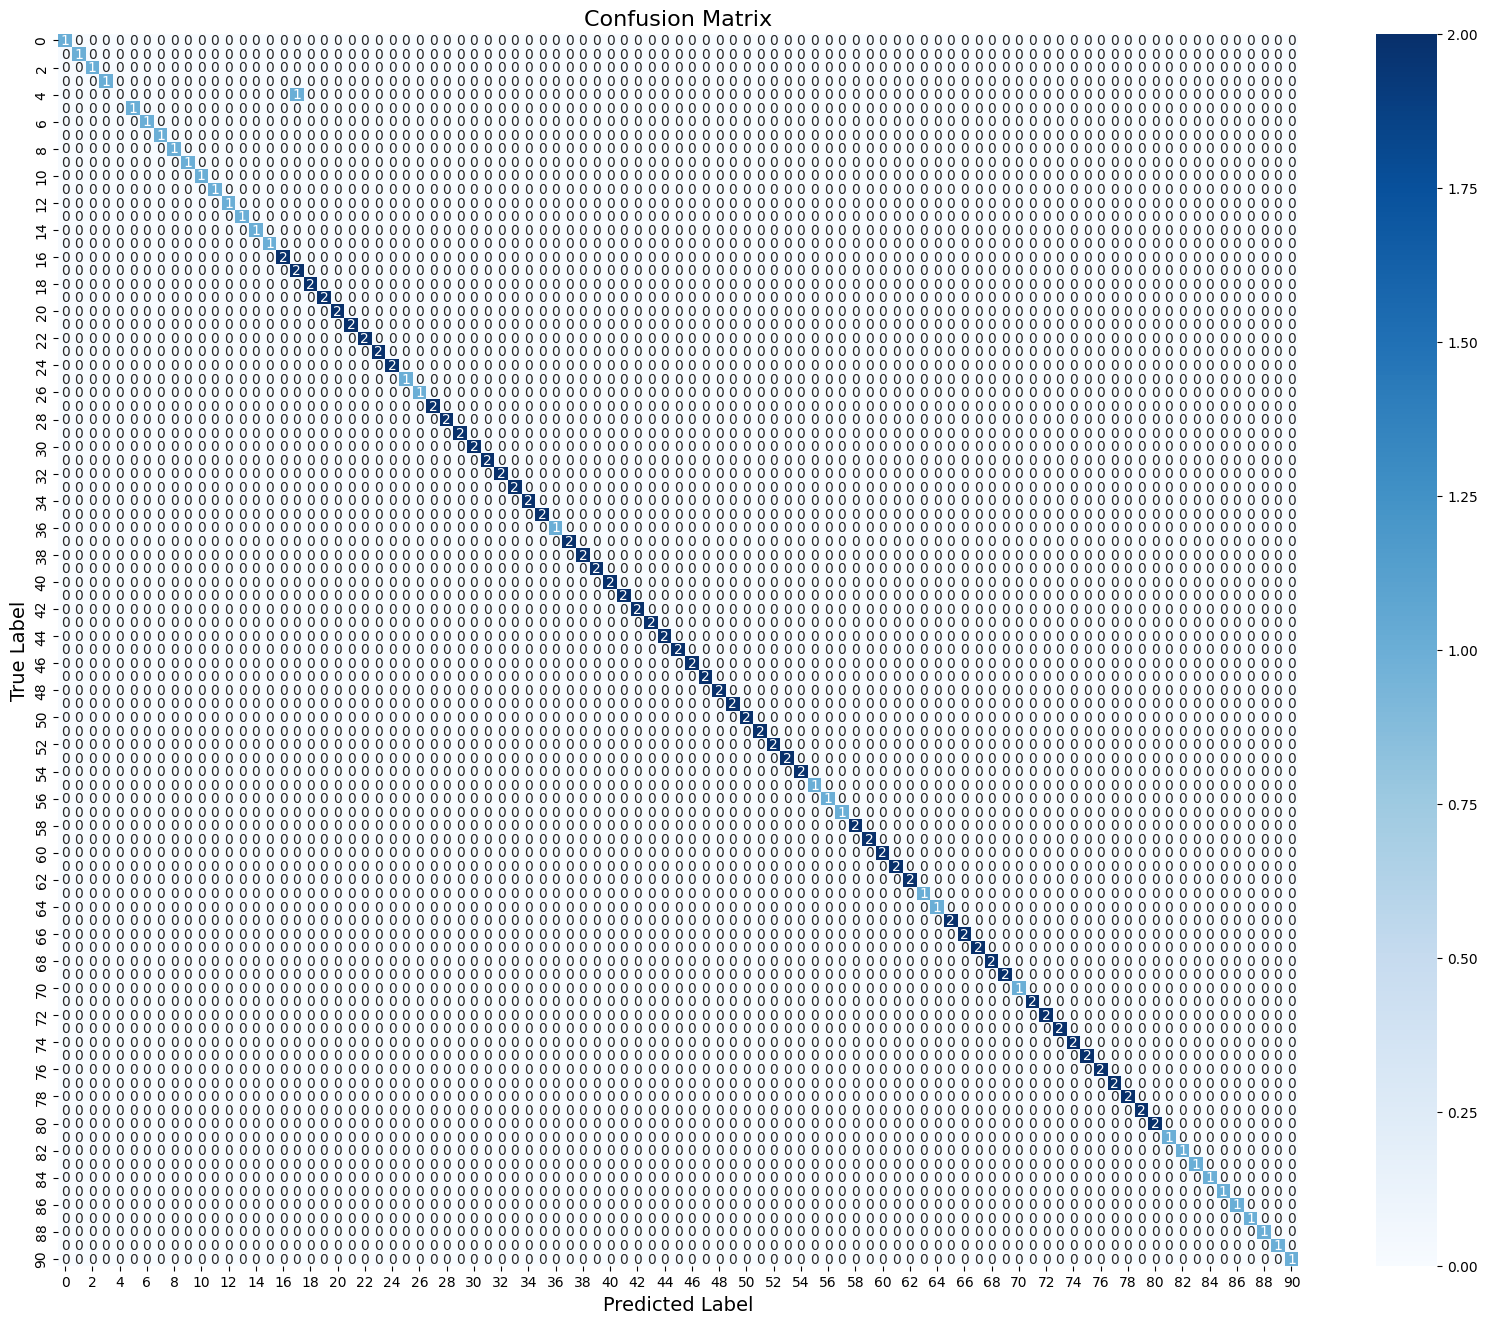

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 예측값
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


# 실제 음원에 적용

주어진 경로 (/content/drive/My Drive/soundAI/MCR_D.mp3)의 MP3 파일을 로드하고 0.07초 단위로 자릅니다.

모델 (/content/drive/My Drive/soundAI/0601_model.h5)을 로드합니다.

세그먼트된 오디오를 모델 입력 형식으로 전처리합니다.

모델을 사용하여 세그먼트를 예측하고 예측된 라벨을 출력합니다.

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 필요한 패키지 설치
!pip install librosa tensorflow

# 1. 라이브러리 임포트
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

input shape 맞춰야해!!

드럼 소리를 0.07초씩 분할합니다.

각 분할된 소리에 대해 STFT를 계산하고 모델의 입력 형식에 맞게 패딩합니다.

모델에 입력하여 예측 결과를 저장합니다.

예측 결과를 pandas DataFrame에 저장하고 CSV 파일로 저장합니다.

matplotlib를 사용하여 각 라벨에 대한 예측 결과를 시각화합니다.

In [ ]:

# 모델 로드
model_path = '/content/drive/My Drive/soundAI/0601_model.h5'
model = tf.keras.models.load_model(model_path)

# 오디오 파일 로드 및 분할
audio_path = '/content/drive/My Drive/soundAI/MCR_D.mp3'
y, sr = librosa.load(audio_path, sr=None)  # 원본 샘플링 레이트 유지
duration = 0.07  # 0.07초
samples_per_segment = int(duration * sr)

# 분할 후 STFT 변환 및 패딩
segments = []
for start in range(0, len(y), samples_per_segment):
    segment = y[start:start + samples_per_segment]
    if len(segment) == samples_per_segment:
        stft = librosa.stft(segment, n_fft=2048, hop_length=512)
        stft_db = librosa.amplitude_to_db(abs(stft))
        if stft_db.shape[1] < 130:  # 모델의 기대 입력 크기와 맞추기 위해 패딩
            padding = np.zeros((stft_db.shape[0], 130 - stft_db.shape[1]))
            stft_db = np.hstack((stft_db, padding))
        segments.append(stft_db)

# 모델 입력 형식에 맞게 변환
segments = np.array(segments)
segments = segments[..., np.newaxis]  # 모델의 입력 차원에 맞게 추가 차원 추가

# 예측 수행
predictions = []
for segment in segments:
    segment = segment.reshape(1, *segment.shape)  # 모델 입력 형태에 맞게 변형
    prediction = model.predict(segment)
    predictions.append(prediction)

# 예측 결과 출력
for i, prediction in enumerate(predictions):
    print(f"Segment {i}: {prediction}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  0.0000000e+00 0.0000000e+00]]
Segment 2792: [[5.6697343e-29 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.3022865e-33 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.0208045e-28 0.0000000e+00 0.0000000e+00 6.2222830e-29
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.1619462e-38 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.1777708e-38 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4076802e

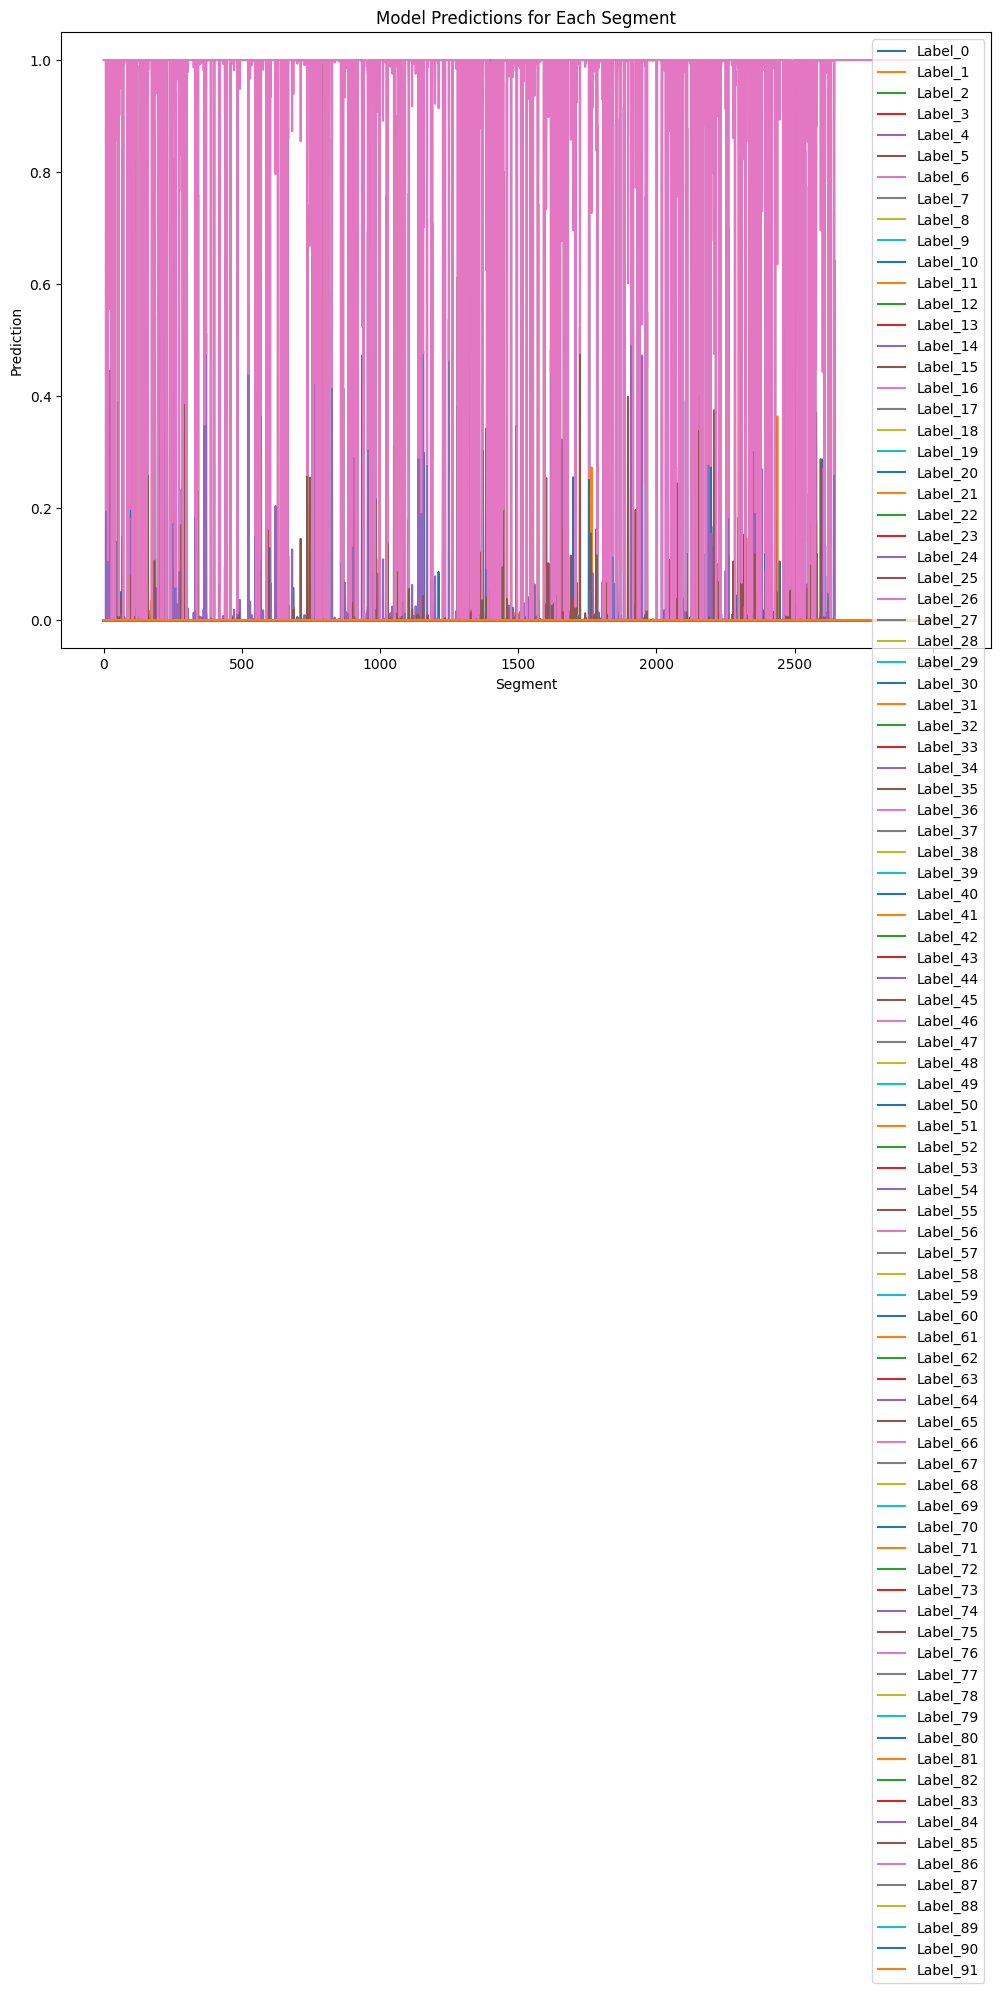

Predictions saved to /content/drive/My Drive/soundAI/predictions.csv


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd



# 예측 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame(np.vstack(predictions), columns=[f'Label_{i}' for i in range(predictions[0].shape[1])])
results_df['Segment'] = results_df.index

# 예측 결과 시각화
plt.figure(figsize=(12, 8))
for i in range(predictions[0].shape[1]):
    plt.plot(results_df['Segment'], results_df[f'Label_{i}'], label=f'Label_{i}')
plt.xlabel('Segment')
plt.ylabel('Prediction')
plt.title('Model Predictions for Each Segment')
plt.legend()
plt.show()

# 예측 결과 저장
results_path = '/content/drive/My Drive/soundAI/predictions.csv'
results_df.to_csv(results_path, index=False)
print(f"Predictions saved to {results_path}")


모델이 음원에 잘 적용되는지를 확인하기 위해서는 예측 결과를 실제 라벨과 비교하여 정확도를 평가

가장 높은 확률을 갖는 라벨을 표시: 각 세그먼트에 대해 모델이 예측한 가장 높은 확률의 라벨을 시각화합니다.
정확도 평가: 실제 라벨이 있다면, 예측 결과와 실제 라벨을 비교하여 정확도를 계산합니다.

1/1 [==============================] - 0s 18ms/step


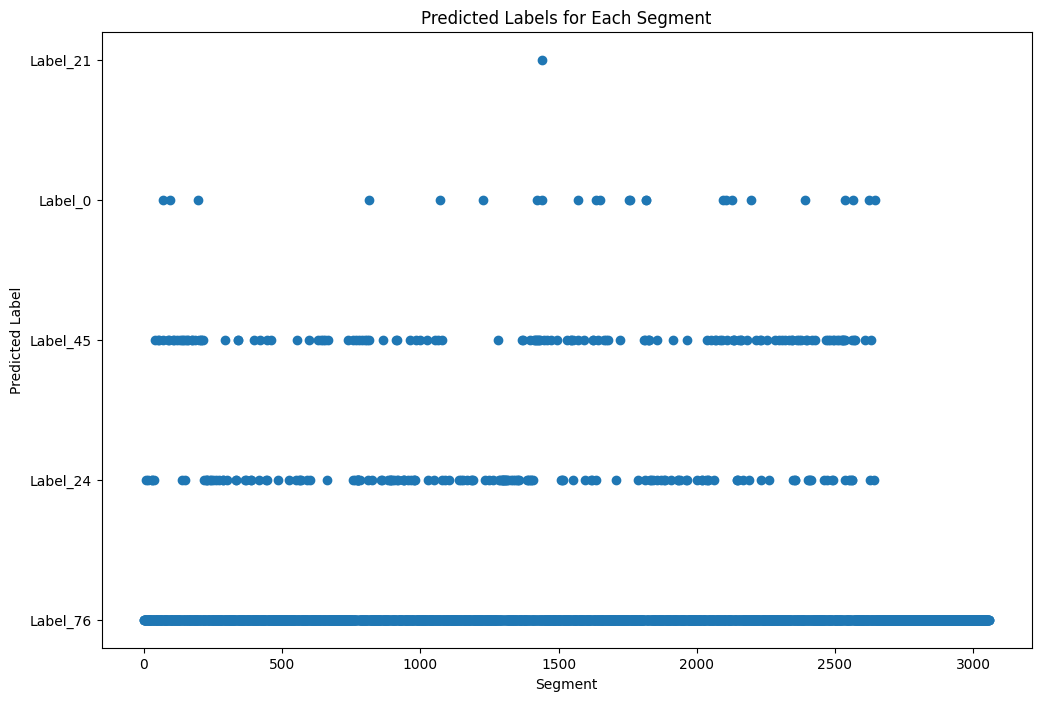

Predictions saved to /content/drive/My Drive/soundAI/predictions_1.csv


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd

# 모델 로드
model_path = '/content/drive/My Drive/soundAI/0601_model.h5'
model = tf.keras.models.load_model(model_path)

# 오디오 파일 로드 및 분할
audio_path = '/content/drive/My Drive/soundAI/MCR_D.mp3'
y, sr = librosa.load(audio_path, sr=None)  # 원본 샘플링 레이트 유지
duration = 0.07  # 0.07초
samples_per_segment = int(duration * sr)

# 분할 후 STFT 변환 및 패딩
segments = []
for start in range(0, len(y), samples_per_segment):
    segment = y[start:start + samples_per_segment]
    if len(segment) == samples_per_segment:
        stft = librosa.stft(segment, n_fft=2048, hop_length=512)
        stft_db = librosa.amplitude_to_db(abs(stft))
        if stft_db.shape[1] < 130:  # 모델의 기대 입력 크기와 맞추기 위해 패딩
            padding = np.zeros((stft_db.shape[0], 130 - stft_db.shape[1]))
            stft_db = np.hstack((stft_db, padding))
        segments.append(stft_db)

# 모델 입력 형식에 맞게 변환
segments = np.array(segments)
segments = segments[..., np.newaxis]  # 모델의 입력 차원에 맞게 추가 차원 추가

# 예측 수행 및 결과 저장
predictions = []
for segment in segments:
    segment = segment.reshape(1, *segment.shape)  # 모델 입력 형태에 맞게 변형
    prediction = model.predict(segment)
    predictions.append(prediction)

# 예측 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame(np.vstack(predictions), columns=[f'Label_{i}' for i in range(predictions[0].shape[1])])
results_df['Segment'] = results_df.index

# 각 세그먼트에 대해 가장 높은 확률을 갖는 라벨을 시각화
results_df['Predicted_Label'] = results_df.iloc[:, :-1].idxmax(axis=1)

# 예측 결과 시각화
plt.figure(figsize=(12, 8))
plt.plot(results_df['Segment'], results_df['Predicted_Label'], 'o')
plt.xlabel('Segment')
plt.ylabel('Predicted Label')
plt.title('Predicted Labels for Each Segment')
plt.show()

# 예측 결과 저장
results_path = '/content/drive/My Drive/soundAI/predictions_1.csv'
results_df.to_csv(results_path, index=False)
print(f"Predictions saved to {results_path}")


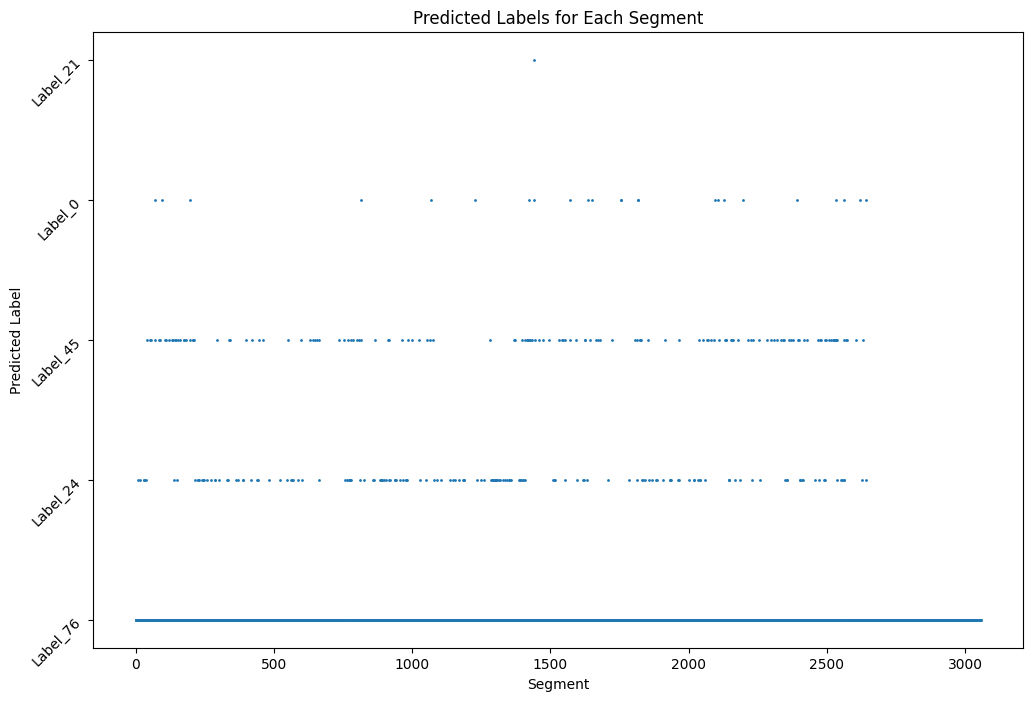

Predictions saved to /content/drive/My Drive/soundAI/predictions_2.csv


In [ ]:
# 예측 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame(np.vstack(predictions), columns=[f'Label_{i}' for i in range(predictions[0].shape[1])])
results_df['Segment'] = results_df.index

# 각 세그먼트에 대해 가장 높은 확률을 갖는 라벨을 시각화
results_df['Predicted_Label'] = results_df.iloc[:, :-1].idxmax(axis=1)

# 예측 결과 시각화
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Segment'], results_df['Predicted_Label'], s=1)
plt.xlabel('Segment')
plt.ylabel('Predicted Label')
plt.title('Predicted Labels for Each Segment')
plt.yticks(rotation=45)
plt.show()

# 예측 결과 저장
results_path = '/content/drive/My Drive/soundAI/predictions_2.csv'
results_df.to_csv(results_path, index=False)
print(f"Predictions saved to {results_path}")


Label_0, Label_21, Label_24, Label_45, Label_76이 라벨들이 대부분의 세그먼트에서 예측됨

Label_0, Label_21, Label_24, Label_45, Label_76이 노래에서 주된 라벨음향인가봄

특히 Label_76은 거의 모든 세그먼트에서 예측됨


이 코드에 실제 라벨 데이터를 제공하면 모델의 성능을 평가할 수 있음

실제 라벨 데이터를 찾아보자...
df_concat에서 전처리된 데이터가 실제 라벨 데이터겠지?